##AdaBoost

The project aims to create a predictive model to forecast whether a basketball player will get drafted into the NBA based on their performance matrices.

In this experiment, I aim to determine how well an XGBoost model with hyperparameterization with L2 regularization can predict the drafting of players in NBA.

The metric used to assess the performance of classification model is AUROC.


##Import packages and load the dataset

In [54]:
#import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

import warnings
warnings.filterwarnings('ignore')

I have created a reprository 'Adv_MLA' on my github.

In [55]:
#set path to project folder
import sys
sys.path.append('C:/Users/saumy/OneDrive/Desktop/Semester-3/AdvMLA/Adv_MLA')

# Import the required functions or classes from the module
from src.data.datapreprocess import DataProcessor

# Create an instance of the DataProcessor class
data_processor = DataProcessor()

# Load the data
df_train = pd.read_csv('https://raw.githubusercontent.com/bhutanisaumya/AMLA/main/train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/bhutanisaumya/AMLA/main/test.csv')




##Data Exploration
I will be performing data explorations on both test and train datasets.

###Train Dataset

In [56]:
#explore the train data
data_processor.explore_data(df_train)

First 5 rows:
            team conf  GP  Min_per   Ortg   usg   eFG  TS_per  ORB_per  \
0  South Alabama   SB  26     29.5   97.3  16.6  42.5   44.43      1.6   
1       Utah St.  WAC  34     60.9  108.3  14.9  52.4   54.48      3.8   
2  South Florida   BE  27     72.0   96.2  21.8  45.7   47.98      2.1   
3     Pepperdine  WCC  30     44.5   97.7  16.0  53.6   53.69      4.1   
4        Pacific   BW  33     56.2   96.5  22.0  52.8   54.31      8.3   

   DRB_per  ...     dgbpm    oreb    dreb    treb     ast     stl     blk  \
0      4.6  ... -1.941150  0.1923  0.6154  0.8077  1.1923  0.3462  0.0385   
1      6.3  ... -0.247934  0.6765  1.2647  1.9412  1.8235  0.4118  0.2353   
2      8.0  ... -0.883163  0.6296  2.3333  2.9630  1.9630  0.4815  0.0000   
3      9.4  ... -0.393459  0.7000  1.4333  2.1333  1.1000  0.5667  0.1333   
4     18.6  ... -0.668318  1.4242  3.3030  4.7273  0.8485  0.4545  0.3333   

       pts                             player_id  drafted  
0   3.8846  7be2ae

team          0
conf          0
GP            0
Min_per       0
Ortg          0
             ..
stl          38
blk          38
pts          38
player_id     0
drafted       0
Length: 64, dtype: int64


###Test Dataset

In [57]:
#explore the test data
data_processor.explore_data(df_test)

First 5 rows:
                 team  conf  GP  Min_per   Ortg   usg   eFG  TS_per  ORB_per  \
0          Morgan St.  MEAC   2      3.0  115.1   4.7  50.0   50.00      0.0   
1  South Carolina St.  MEAC  11     17.6   61.1  18.6  34.7   35.18      2.5   
2          Binghamton    AE   9     28.6   91.9  23.8  54.1   52.49      6.4   
3            Illinois   B10   7      1.3  111.0  10.4  83.3   83.33      0.0   
4            Iowa St.   B12  23     78.5  103.1  21.5  54.0   56.12      3.6   

   DRB_per  ...     ogbpm     dgbpm    oreb    dreb    treb     ast     stl  \
0      4.6  ... -2.467740 -2.275660  0.0000  0.3333  0.3333  0.0000  0.0000   
1     15.7  ... -7.494720 -4.412530  0.2727  1.4545  1.7273  0.4545  0.1818   
2     22.5  ... -2.924950  1.717890  1.3333  4.4444  5.7778  1.0000  0.6667   
3     13.4  ... -0.767911  0.962469  0.0000  0.2857  0.2857  0.0000  0.0000   
4     10.2  ...  2.893610 -1.019000  1.0435  2.8696  3.9130  1.1739  0.8261   

      blk      pts            

##Data Preparation and cleaning

###Train Dataset

In [58]:
#sum of null values in the dataframe
df_train.isnull().sum()

team          0
conf          0
GP            0
Min_per       0
Ortg          0
             ..
stl          38
blk          38
pts          38
player_id     0
drafted       0
Length: 64, dtype: int64

<Axes: >

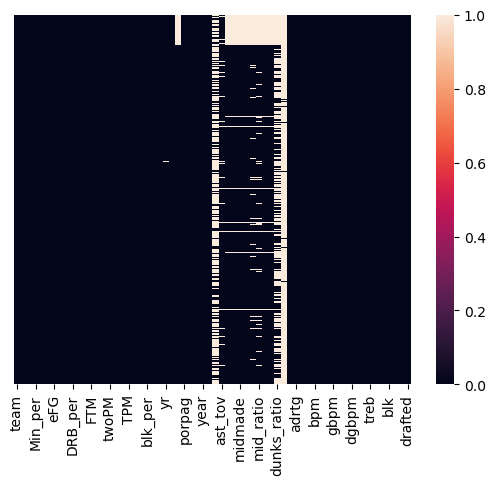

In [59]:
#heatmap highlighing null values in the dataframe
sns.heatmap(df_train.isnull(), yticklabels = False)

The above heatmap shows null values in the dataframe.
To handle null values in these columns, I will impute the null values with mean values.
But for the columns where half of the rows are empty.I will not make any imputations rather I will drop the column as imputing with mean of very less data points will lead to inaccurate data.

In [60]:
#copy the dataframe
df_train_clean = df_train.copy()

In [61]:
#checking missimng values in specific columns
columns_to_check = [ 'Rec_Rank', 'pick', 'midmade', 'midmade_midmiss', 'rim_ratio', 'mid_ratio', 'dunksmade', 'dunksmiss_dunksmade', 'dunks_ratio']
missing_counts = df_train_clean[columns_to_check].isnull().sum()

print("Missing Value Counts:")
print(missing_counts)


Missing Value Counts:
Rec_Rank               39055
pick                   54705
midmade                 6081
midmade_midmiss         6081
rim_ratio               9464
mid_ratio               9688
dunksmade               6081
dunksmiss_dunksmade     6081
dunks_ratio            30793
dtype: int64


The features ‘pick’ and  'Rec_Rank' have a high percentage of missing values of more than 97% and 69%, respectively. Therefore, I am dropping these columns.

In [62]:
# List of columns to drop
cols_to_drop = ['Rec_Rank', 'pick']

# Drop the specified columns
df_train_clean.drop(columns=cols_to_drop, inplace=True)

In [63]:
#calculate mean (ast_tov, rimmrade, rimmade_rimmiss, midmade, midmade_midmiss, dunksmade, dunksmiss_dunksmade)
ast_tov_train_mean = df_train_clean['ast_tov'].mean()
rimmade_train_mean = df_train_clean['rimmade'].mean()
rimmade_rimmiss_train_mean = df_train_clean['rimmade_rimmiss'].mean()
midmade_train_mean = df_train_clean['midmade'].mean()
midmade_midmiss_train_mean = df_train_clean['midmade_midmiss'].mean()
dunksmade_train_mean = df_train_clean['dunksmade'].mean()
dunksmiss_dunksmade_train_mean = df_train_clean['dunksmiss_dunksmade'].mean()

#imputing the missing values with mean
df_train_clean['ast_tov'] = df_train_clean['ast_tov'].fillna(ast_tov_train_mean)
df_train_clean['rimmade'] = df_train_clean['rimmade'].fillna(rimmade_train_mean)
df_train_clean['rimmade_rimmiss'] = df_train_clean['rimmade_rimmiss'].fillna(rimmade_rimmiss_train_mean)
df_train_clean['midmade'] = df_train_clean['midmade'].fillna(midmade_train_mean)
df_train_clean['midmade_midmiss'] = df_train_clean['midmade_midmiss'].fillna(midmade_midmiss_train_mean)
df_train_clean['dunksmade'] = df_train_clean['dunksmade'].fillna(dunksmade_train_mean)
df_train_clean['dunksmiss_dunksmade'] = df_train_clean['dunksmiss_dunksmade'].fillna(dunksmiss_dunksmade_train_mean)

In [64]:
# Calculate ratio (rim_ratio, mid_ratio, dunks_ratio)
rim_ratio_train = df_train_clean['rimmade'] / df_train_clean['rimmade_rimmiss']
mid_ratio_train = df_train_clean['midmade'] / df_train_clean['midmade_midmiss']
dunks_ratio_train = df_train_clean['dunksmade'] / df_train_clean['dunksmiss_dunksmade']

# Impute the missing values with calculated ratios
df_train_clean['rim_ratio'] = df_train_clean['rim_ratio'].fillna(rim_ratio_train)
df_train_clean['mid_ratio'] = df_train_clean['mid_ratio'].fillna(mid_ratio_train)
df_train_clean['dunks_ratio'] = df_train_clean['dunks_ratio'].fillna(dunks_ratio_train)


In [65]:
# List of ratio columns
ratio_columns = ['rim_ratio', 'mid_ratio', 'dunks_ratio']

# Replace NaN values with 0 in the ratio columns
for col in ratio_columns:
    df_train_clean[col][pd.isna(df_train_clean[col])] = 0


In [66]:
#check for null values after imputations
columns_to_check = [ 'yr', 'num']
missing = df_train_clean[columns_to_check].isnull().sum()

print("Missing Value Counts:")
print(missing)

Missing Value Counts:
yr      274
num    4669
dtype: int64


The columns 'yr' and 'num' contain a lot of irregularities. Since the data is unreliable. Thus I have decided to remove these columns.

In [67]:
# List of columns to drop
to_drop = ['yr', 'num']
# Drop the specified columns
df_train_clean.drop(columns=to_drop, inplace=True)

In [68]:
#handling column 'ht'
from datetime import datetime

# Function to convert date strings to float
def convert_date_to_float(date_str):
    if isinstance(date_str, str):
        parts = date_str.split('-')
        if len(parts) == 2:
            try:
                day = parts[0]
                month = parts[1]

                # Create a datetime object with a dummy year (e.g., 2023)
                date_object = datetime.strptime(f"2023-{month}-{day}", "%Y-%b-%d")

                # Convert the datetime object to a float representing 2/06/2023
                float_date = float(date_object.strftime("%m.%d"))
                return float_date
            except ValueError:
                return None  # Handle non-convertible values here if needed
        else:
            return None  # Handle cases where the date format is not as expected
    else:
        return date_str  # Return the value as is if it's not a string

# Apply the conversion function to the 'ht' column
df_train_clean['ht'] = df_train_clean['ht'].apply(convert_date_to_float)
import pandas as pd
from datetime import datetime



In [69]:
# Replace NaN values with 0 in the 'ht' column
df_train_clean['ht'].fillna(0, inplace=True)

In [70]:
df_train_clean['ht'].head(40)

0     6.02
1     6.04
2     6.04
3     6.04
4     6.08
5     6.01
6     6.05
7     0.00
8     6.06
9     6.05
10    6.08
11    6.05
12    6.05
13    6.09
14    6.05
15    6.06
16    6.03
17    6.04
18    6.04
19    6.09
20    6.11
21    6.07
22    6.02
23    6.05
24    6.02
25    6.02
26    6.04
27    6.02
28    6.07
29    6.06
30    6.04
31    6.02
32    5.10
33    6.03
34    6.03
35    6.10
36    6.08
37    6.02
38    6.06
39    5.11
Name: ht, dtype: float64

In [71]:
#check for null values after imputations
df_train_clean.isnull().sum()

team                    0
conf                    0
GP                      0
Min_per                 0
Ortg                    0
usg                     0
eFG                     0
TS_per                  0
ORB_per                 0
DRB_per                 0
AST_per                 0
TO_per                  0
FTM                     0
FTA                     0
FT_per                  0
twoPM                   0
twoPA                   0
twoP_per                0
TPM                     0
TPA                     0
TP_per                  0
blk_per                 0
stl_per                 0
ftr                     0
ht                      0
porpag                  0
adjoe                   0
pfr                     0
year                    0
type                    0
ast_tov                 0
rimmade                 0
rimmade_rimmiss         0
midmade                 0
midmade_midmiss         0
rim_ratio               0
mid_ratio               0
dunksmade               0
dunksmiss_du

In [72]:
# List of columns to impute with average
columns_to_impute = [
    'drtg', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'mp', 'ogbpm', 'dgbpm',
    'oreb', 'dreb', 'treb', 'ast', 'stl', 'blk', 'pts'
]

# Impute the average value to specified columns
for col in columns_to_impute:
    avg_value = df_train_clean[col].mean()
    df_train_clean[col].fillna(avg_value, inplace=True)

In [73]:
#check for null values
df_train_clean.isnull().sum()

team                   0
conf                   0
GP                     0
Min_per                0
Ortg                   0
usg                    0
eFG                    0
TS_per                 0
ORB_per                0
DRB_per                0
AST_per                0
TO_per                 0
FTM                    0
FTA                    0
FT_per                 0
twoPM                  0
twoPA                  0
twoP_per               0
TPM                    0
TPA                    0
TP_per                 0
blk_per                0
stl_per                0
ftr                    0
ht                     0
porpag                 0
adjoe                  0
pfr                    0
year                   0
type                   0
ast_tov                0
rimmade                0
rimmade_rimmiss        0
midmade                0
midmade_midmiss        0
rim_ratio              0
mid_ratio              0
dunksmade              0
dunksmiss_dunksmade    0
dunks_ratio            0


###Test Dataset

In [74]:
#sum of null values in the dataframe
df_test.isnull().sum()

team         0
conf         0
GP           0
Min_per      0
Ortg         0
            ..
ast          0
stl          0
blk          0
pts          0
player_id    0
Length: 63, dtype: int64

<Axes: >

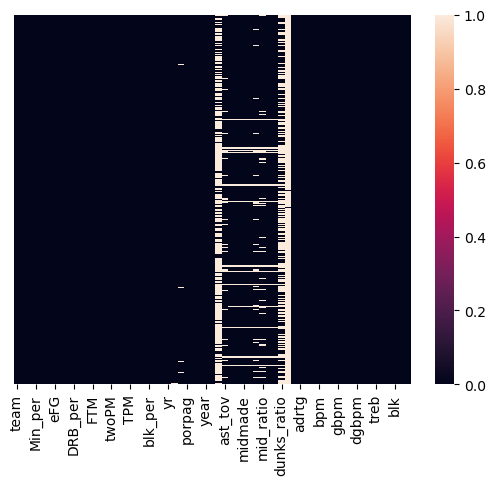

In [75]:
#heatmap highlighing null values in the dataframe
sns.heatmap(df_test.isnull(), yticklabels = False)

The above heatmap shows null values in the dataframe.
To handle null values in these columns, I will impute the null values with mean values.
But for the columns where half of the rows are empty.I will not make any imputations rather I will drop the column as imputing with mean of very less data points will lead to inaccurate data.

In [76]:
#copy the dataframe
df_test_clean = df_test.copy()

Performing similar imputations as performed in training dataset

In [77]:
# List of columns to drop
cols_to_drop = ['Rec_Rank', 'pick']

# Drop the specified columns
df_test_clean.drop(columns=cols_to_drop, inplace=True)

In [78]:
#calculate mean (ast_tov, rimmrade, rimmade_rimmiss, midmade, midmade_midmiss, dunksmade, dunksmiss_dunksmade)
ast_tov_test_mean = df_test_clean['ast_tov'].mean()
rimmade_test_mean = df_test_clean['rimmade'].mean()
rimmade_rimmiss_test_mean = df_test_clean['rimmade_rimmiss'].mean()
midmade_test_mean = df_test_clean['midmade'].mean()
midmade_midmiss_test_mean = df_test_clean['midmade_midmiss'].mean()
dunksmade_test_mean = df_test_clean['dunksmade'].mean()
dunksmiss_dunksmade_test_mean = df_test_clean['dunksmiss_dunksmade'].mean()

#impute the null values with mean
df_test_clean['ast_tov'] = df_test_clean['ast_tov'].fillna(ast_tov_test_mean)
df_test_clean['rimmade'] = df_test_clean['rimmade'].fillna(rimmade_test_mean)
df_test_clean['rimmade_rimmiss'] = df_test_clean['rimmade_rimmiss'].fillna(rimmade_rimmiss_test_mean)
df_test_clean['midmade'] = df_test_clean['midmade'].fillna(midmade_test_mean)
df_test_clean['midmade_midmiss'] = df_test_clean['midmade_midmiss'].fillna(midmade_midmiss_test_mean)
df_test_clean['dunksmade'] = df_test_clean['dunksmade'].fillna(dunksmade_test_mean)
df_test_clean['dunksmiss_dunksmade'] = df_test_clean['dunksmiss_dunksmade'].fillna(dunksmiss_dunksmade_test_mean)

In [79]:
# Calculate ratio (rim_ratio, mid_ratio, dunks_ratio)
rim_ratio_test = df_test_clean['rimmade'] / df_test_clean['rimmade_rimmiss']
mid_ratio_test = df_test_clean['midmade'] / df_test_clean['midmade_midmiss']
dunks_ratio_test = df_test_clean['dunksmade'] / df_test_clean['dunksmiss_dunksmade']

# Impute the null values with calculated ratios
df_test_clean['rim_ratio'] = df_test_clean['rim_ratio'].fillna(rim_ratio_test)
df_test_clean['mid_ratio'] = df_test_clean['mid_ratio'].fillna(mid_ratio_test)
df_test_clean['dunks_ratio'] = df_test_clean['dunks_ratio'].fillna(dunks_ratio_test)


In [80]:
# List of ratio columns
ratio_columns = ['rim_ratio', 'mid_ratio', 'dunks_ratio']

# Replace NaN values with 0 in the ratio columns
for col in ratio_columns:
    df_test_clean[col][pd.isna(df_test_clean[col])] = 0


The columns 'yr' and 'num' contain a lot of irregularities. Since the data is unreliable. Thus I have decided to remove these columns.

In [81]:
# List of columns to drop
to_drop = ['yr', 'num']
# Drop the specified columns
df_test_clean.drop(columns=to_drop, inplace=True)

In [82]:
# Apply the conversion function to the 'ht' column
df_test_clean['ht'] = df_test_clean['ht'].apply(convert_date_to_float)

In [83]:
df_test_clean['ht'].head(40)

0     6.04
1      NaN
2     6.09
3     6.02
4     6.04
5     6.03
6     6.10
7     6.01
8     6.06
9     6.05
10    6.02
11    6.10
12    6.11
13    6.07
14    6.09
15    6.10
16    6.08
17    6.02
18    6.11
19    6.07
20    6.02
21    6.02
22     NaN
23    6.08
24    5.11
25    6.02
26    6.08
27    6.01
28     NaN
29    6.09
30    6.07
31    6.05
32    6.05
33    6.02
34    6.03
35    6.08
36    6.03
37    6.01
38    6.03
39    6.08
Name: ht, dtype: float64

In [84]:
# Replace NaN values with 0 in the 'ht' column
df_test_clean['ht'].fillna(0, inplace=True)

In [85]:
#check for null values after imputations
df_test_clean.isnull().sum()

team                   0
conf                   0
GP                     0
Min_per                0
Ortg                   0
usg                    0
eFG                    0
TS_per                 0
ORB_per                0
DRB_per                0
AST_per                0
TO_per                 0
FTM                    0
FTA                    0
FT_per                 0
twoPM                  0
twoPA                  0
twoP_per               0
TPM                    0
TPA                    0
TP_per                 0
blk_per                0
stl_per                0
ftr                    0
ht                     0
porpag                 0
adjoe                  0
pfr                    0
year                   0
type                   0
ast_tov                0
rimmade                0
rimmade_rimmiss        0
midmade                0
midmade_midmiss        0
rim_ratio              0
mid_ratio              0
dunksmade              0
dunksmiss_dunksmade    0
dunks_ratio            0


In [86]:
# List of columns to impute with average
columns_to_impute = [
    'drtg', 'adrtg', 'dporpag', 'stops', 'bpm', 'obpm', 'dbpm', 'gbpm', 'ogbpm', 'dgbpm'
]

# Impute the average value to specified columns
for col in columns_to_impute:
    avg_value = df_test_clean[col].mean()
    df_test_clean[col].fillna(avg_value, inplace=True)

##Identifying relationships


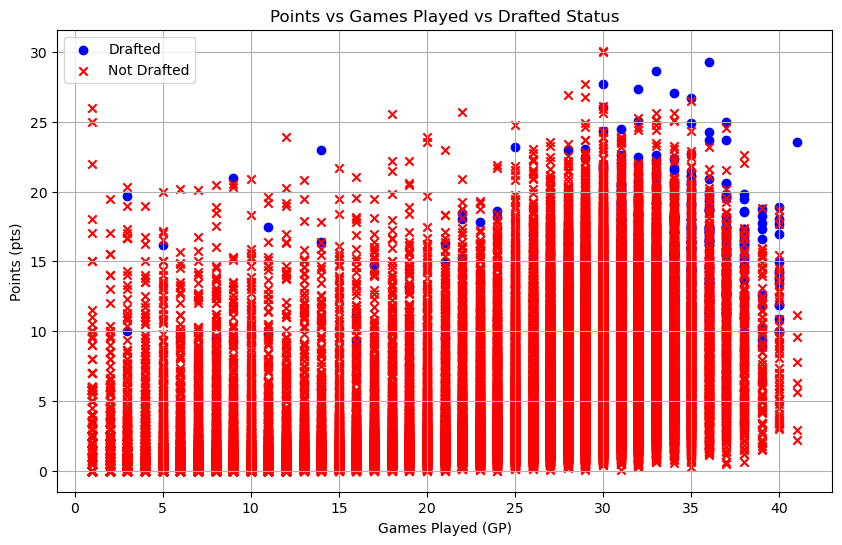

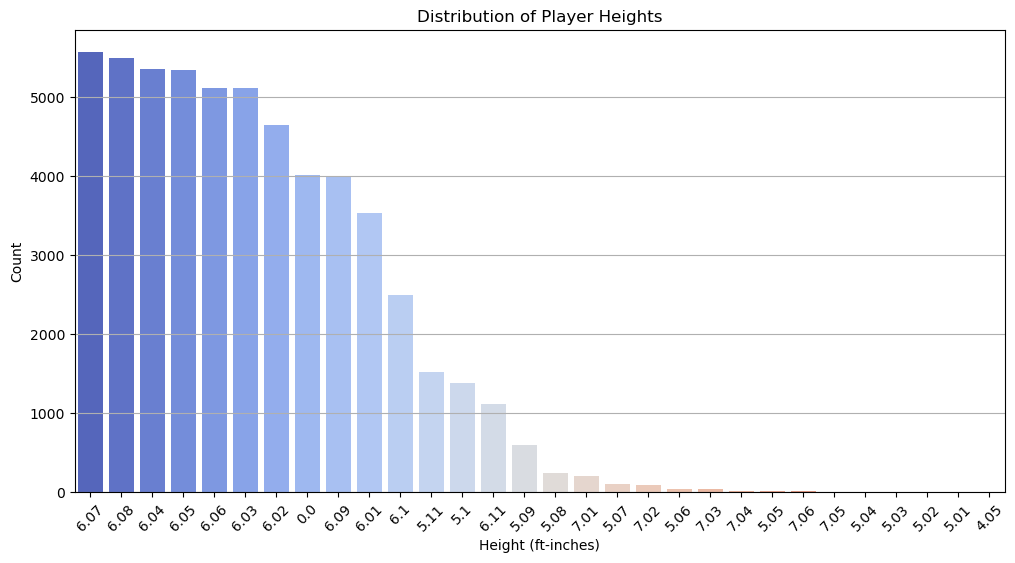

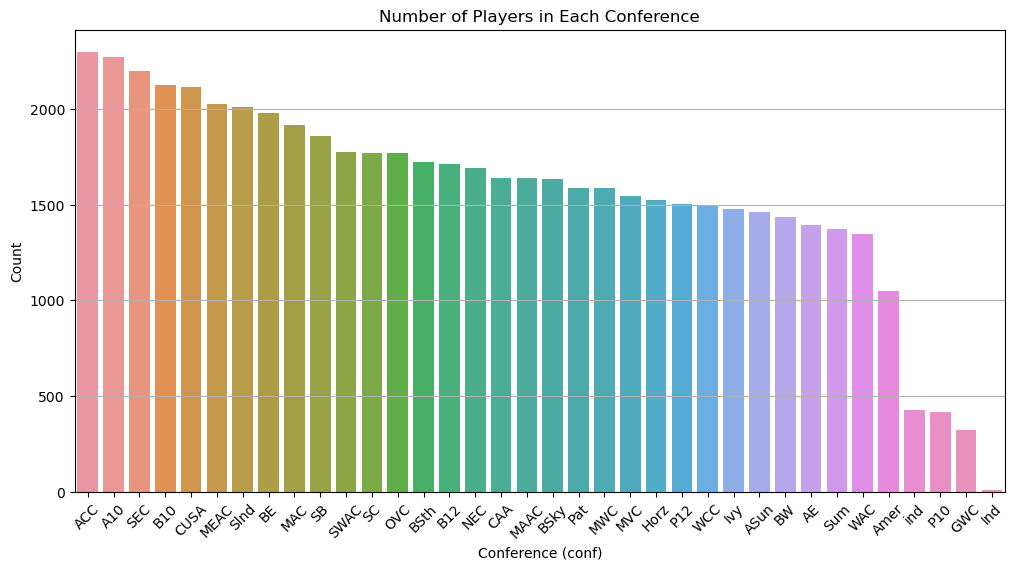

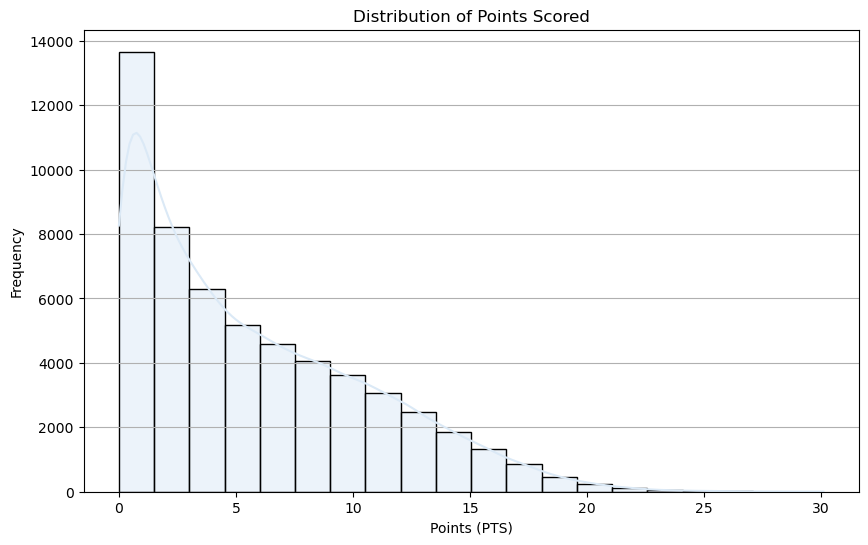

In [87]:
# Import the 'visualize_data' function from the 'src.visualization.visualize' module
from src.visualization.visualize import visualize_data

# Call the 'visualize_data' function with the 'df_train' DataFrame as input
visualize_data(df_train_clean)

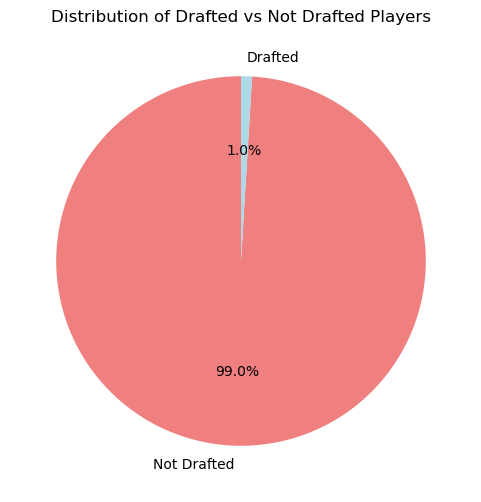

In [88]:
plt.figure(figsize=(6, 6))
drafted_counts = df_train_clean['drafted'].value_counts()
plt.pie(drafted_counts, labels=['Not Drafted', 'Drafted'], autopct='%1.1f%%', colors=['lightcoral', 'lightblue'], startangle=90)
plt.title('Distribution of Drafted vs Not Drafted Players')
plt.show()

I will generate correlation matrix to understand the relationship between the target feature and other features.

<Axes: >

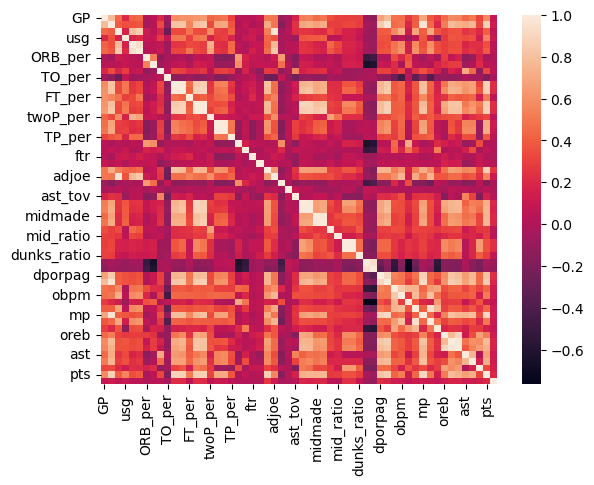

In [89]:
corr_matrix = df_train_clean.corr()
sns.heatmap(corr_matrix)

In [90]:
corr_matrix

,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,AST_per,TO_per,...,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,drafted
GP,1.000000,0.780850,0.443309,0.193908,0.416546,0.434722,-0.005510,0.037280,0.193153,-0.044621,...,0.375688,0.287354,0.444542,0.570031,0.557943,0.444210,0.507958,0.312446,0.566343,0.096567
Min_per,0.780850,1.000000,0.398857,0.349819,0.346221,0.379121,-0.051825,0.033872,0.335007,-0.119816,...,0.437588,0.192223,0.518478,0.780668,0.732328,0.707774,0.754155,0.329065,0.869411,0.130029
Ortg,0.443309,0.398857,1.000000,0.165410,0.784157,0.849692,0.118376,0.043333,0.180594,-0.285193,...,0.703379,0.369924,0.310267,0.354244,0.358698,0.251685,0.289726,0.201221,0.405889,0.068761
usg,0.193908,0.349819,0.165410,1.000000,0.160583,0.205958,0.087382,0.092843,0.281739,0.080861,...,0.138026,-0.131388,0.271286,0.374454,0.359218,0.333903,0.356104,0.136080,0.546044,0.104023
eFG,0.416546,0.346221,0.784157,0.160583,1.000000,0.934169,0.034630,0.057518,0.074258,-0.062752,...,0.583982,0.338541,0.285155,0.329385,0.332351,0.175005,0.232861,0.228164,0.351124,0.052540
TS_per,0.434722,0.379121,0.849692,0.205958,0.934169,1.000000,0.024408,0.051895,0.104640,-0.058381,...,0.614393,0.353101,0.284585,0.348780,0.345813,0.217745,0.268995,0.214606,0.390201,0.058321
ORB_per,-0.005510,-0.051825,0.118376,0.087382,0.034630,0.024408,1.000000,0.526528,-0.119004,-0.029690,...,0.069681,-0.017234,0.282707,0.079074,0.155175,-0.141088,-0.078666,0.170597,-0.034979,0.012876
DRB_per,0.037280,0.033872,0.043333,0.092843,0.057518,0.051895,0.526528,1.000000,-0.074031,-0.003540,...,-0.002357,0.175686,0.236822,0.276478,0.278078,-0.061808,-0.005274,0.209791,0.058259,0.033361
AST_per,0.193153,0.335007,0.180594,0.281739,0.074258,0.104640,-0.119004,-0.074031,1.000000,0.058321,...,0.257076,0.156388,-0.067338,0.166012,0.093242,0.697033,0.441994,-0.119554,0.319018,0.055421
TO_per,-0.044621,-0.119816,-0.285193,0.080861,-0.062752,-0.058381,-0.029690,-0.003540,0.058321,1.000000,...,-0.385840,-0.113922,-0.093106,-0.110122,-0.110329,-0.005675,-0.057686,-0.051947,-0.181823,-0.032557


In [91]:
corr_features = corr_matrix.nlargest(56, 'drafted')['drafted'].index
print(corr_features)

Index(['drafted', 'porpag', 'dunksmade', 'dunksmiss_dunksmade', 'dporpag',
       'twoPM', 'FTM', 'FTA', 'twoPA', 'midmade', 'pts', 'midmade_midmiss',
       'rimmade', 'stops', 'dreb', 'treb', 'rimmade_rimmiss', 'blk', 'mp',
       'Min_per', 'stl', 'oreb', 'bpm', 'ast', 'gbpm', 'obpm', 'TPM', 'ogbpm',
       'adjoe', 'TPA', 'usg', 'GP', 'dgbpm', 'dunks_ratio', 'dbpm', 'Ortg',
       'FT_per', 'TS_per', 'rim_ratio', 'AST_per', 'eFG', 'twoP_per', 'TP_per',
       'mid_ratio', 'ast_tov', 'DRB_per', 'blk_per', 'stl_per', 'ORB_per',
       'ftr', 'ht', 'year', 'pfr', 'TO_per', 'drtg', 'adrtg'],
      dtype='object')


## Data Splitting

In [92]:
from sklearn.model_selection import train_test_split

# Extract the relevant features and target variable
features = ['porpag', 'dunksmade', 'dunksmiss_dunksmade', 'dporpag',
       'twoPM', 'FTM', 'FTA', 'twoPA', 'midmade', 'pts', 'midmade_midmiss',
       'rimmade', 'stops', 'dreb', 'treb', 'rimmade_rimmiss', 'blk', 'mp',
       'Min_per', 'stl', 'oreb', 'bpm', 'ast', 'gbpm', 'obpm', 'TPM', 'ogbpm',
       'adjoe', 'TPA', 'usg', 'GP', 'dgbpm', 'dunks_ratio', 'dbpm', 'Ortg',
       'FT_per', 'TS_per', 'rim_ratio', 'AST_per', 'eFG', 'twoP_per', 'TP_per',
       'mid_ratio', 'ast_tov', 'DRB_per', 'blk_per', 'stl_per', 'ORB_per',
       'ftr', 'ht', 'year', 'pfr', 'TO_per', 'drtg', 'adrtg']
target = ['drafted']

# Extract the features and target from the DataFrame
X = df_train_clean[features]
y = df_train_clean[target]

# Split the dataset into training and validation sets (80% train, 20% validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the split datasets
print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)
print("y_train shape:", y_train.shape)
print("y_val shape:", y_val.shape)


X_train shape: (44872, 55)
X_val shape: (11219, 55)
y_train shape: (44872, 1)
y_val shape: (11219, 1)


In [93]:
X_test = df_test_clean[['porpag', 'dunksmade', 'dunksmiss_dunksmade', 'dporpag',
       'twoPM', 'FTM', 'FTA', 'twoPA', 'midmade', 'pts', 'midmade_midmiss',
       'rimmade', 'stops', 'dreb', 'treb', 'rimmade_rimmiss', 'blk', 'mp',
       'Min_per', 'stl', 'oreb', 'bpm', 'ast', 'gbpm', 'obpm', 'TPM', 'ogbpm',
       'adjoe', 'TPA', 'usg', 'GP', 'dgbpm', 'dunks_ratio', 'dbpm', 'Ortg',
       'FT_per', 'TS_per', 'rim_ratio', 'AST_per', 'eFG', 'twoP_per', 'TP_per',
       'mid_ratio', 'ast_tov', 'DRB_per', 'blk_per', 'stl_per', 'ORB_per',
       'ftr', 'ht', 'year', 'pfr', 'TO_per', 'drtg', 'adrtg']]

#Resampling of Training data

Class 0: 55555
Class 1: 536
Proportion: 103.65 : 1


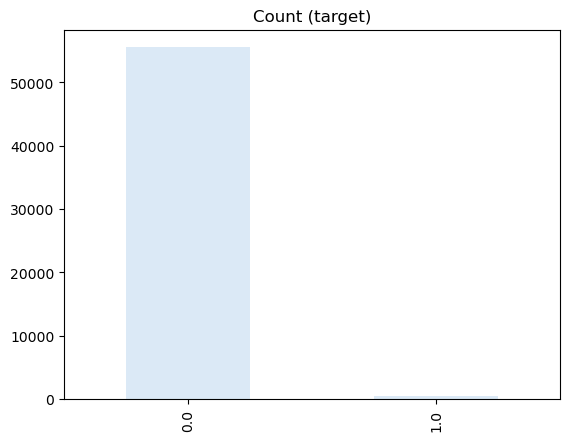

In [94]:
#barplot showing imbalances in dependent feature
target_count = df_train_clean.drafted.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)');

from the above barplot, it is clear that '1' is a minority class.
Resampling of data is important here as there is a  significant class imbalance, wherein one class represents only a small fraction of the dataset. Thus,the model can be biased towards the majority class and making it difficult to predict the minority class accurately.

Resampling the Minority class
I will be performing oversampling of minority class(1) using SMOTE(Synthetic Minority Over-sampling Technique)

In [95]:
y_train = y_train.astype(int)
y_val = y_val.astype(int)

In [96]:
#intall and load necessary libraries
!pip install imblearn
from imblearn.over_sampling import SMOTE

smote = SMOTE()
X_sm, y_sm = smote.fit_resample(X_train, y_train)
X_val_sm, y_val_sm = smote.fit_resample(X_val, y_val)

In [97]:
# Print the number of samples before and after oversampling
print("Before oversampling:")
print(y_train.value_counts())
print("After oversampling(training set):")
print(y_sm.value_counts())
print("After oversampling(validation set):")
print(y_val_sm.value_counts())

Before oversampling:
drafted
0          44435
1            437
dtype: int64
After oversampling(training set):
drafted
0          44435
1          44435
dtype: int64
After oversampling(validation set):
drafted
0          11120
1          11120
dtype: int64


# Scale the data

In [98]:
# Import MinMaxScaler from Sklearn
from sklearn.preprocessing import MinMaxScaler

In [99]:
# Instantiate a MinMaxScaler and save it into a variable called `scaler`
scaler = MinMaxScaler()

In [100]:
#  Fit the scaler on the training set
scaler.fit(X_sm)

MinMaxScaler()

In [101]:
# Apply the scaler on all sets and save the results into separate variables (X_train_scaled, X_val_scaled, X_test_scaled)
X_train_scaled = scaler.transform(X_sm)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

#Baseline Model

In [210]:
# Calculate the average of the target variable for the training set
pred_value = y_train.mean()

In [211]:
# Generate a numpy array with same dimensions as y_train that contains only the value saved in pred_value
y_base = np.full((len(y_train), 1), pred_value)

In [212]:
# Import roc_auc_score from sklearn.metrics
from sklearn.metrics import roc_auc_score

In [213]:
# roc_auc score of baseline model on training set
au_roc = roc_auc_score(y_train, y_base)
print(au_roc)

0.5


#Modelling

In [ ]:
#from sklearn.metrics import roc_auc_score
#from sklearn.model_selection import GridSearchCV
#from xgboost import XGBClassifier

# Create an XGBClassifier
#xgb_model = XGBClassifier(random_state=42)

# Define the hyperparameter grid for tuning
#param_grid = {
    #'learning_rate': [0.01, 0.1, 0.5],
    #'max_depth': [3, 4, 5],
    #'n_estimators': [200, 300, 400],
    #'subsample': [0.8, 0.9, 1.0],
    #'colsample_bytree': [0.8, 0.9, 1.0],
    #'reg_lambda': [0.1, 0.5, 1.0],
    #'min_child_weight': [1, 2, 4]
#}

# Create a GridSearchCV object with the specified parameters
#grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, scoring='roc_auc', cv=5)

# Fit the grid search to the training data
#grid_search.fit(X_train_scaled, y_sm)

# Print the best hyperparameters
#print('Best hyperparameters:', grid_search.best_params_)


In [2]:
print("Best hyperparameters:colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=400, subsample=0.8, reg_lambda = 0.5")

Best hyperparameters:colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=400, subsample=0.8, reg_lambda = 0.5


In [218]:
from xgboost import XGBClassifier
#Instantiate an XGBClassifier with specified hyperparameters
xgb = XGBClassifier(colsample_bytree=0.8, learning_rate=0.01, max_depth=4, min_child_weight=1, n_estimators=400, subsample=0.8, reg_lambda = 0.5, random_state=42)

# Fit the XGBClassifier model with the training data
xgb.fit(X_train_scaled, y_sm)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.01, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=400, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [219]:
# model's prediction on validation set
y_pred_val_xgb = xgb.predict(X_val_scaled)

#roc_au_score on validation set
roc_auc = roc_auc_score(y_val, y_pred_val_xgb)

print(f'ROC AUC score on validation set: {roc_auc:.4f}')

ROC AUC score on validation set: 0.9437


In [222]:
#Test Data
# Predict positive class 1 probabilities for the test data
y_pred_proba_test = xgb.predict_proba(X_test_scaled)[:, 1]


# Print the predicted positive class probabilities
print(y_pred_proba_test)

[0.00906363 0.00906363 0.02505203 ... 0.00906363 0.00906363 0.01449827]


In [225]:
# Adding the 'drafted' column to df_test_clean
df_test_clean['drafted'] = y_pred_proba_test

# Creating the output DataFrame with 'player_id' and 'drafted' columns
output = df_test_clean[['player_id', 'drafted']]

# Save the output DataFrame to a CSV file
output.to_csv('week3_submission.csv', index=False)


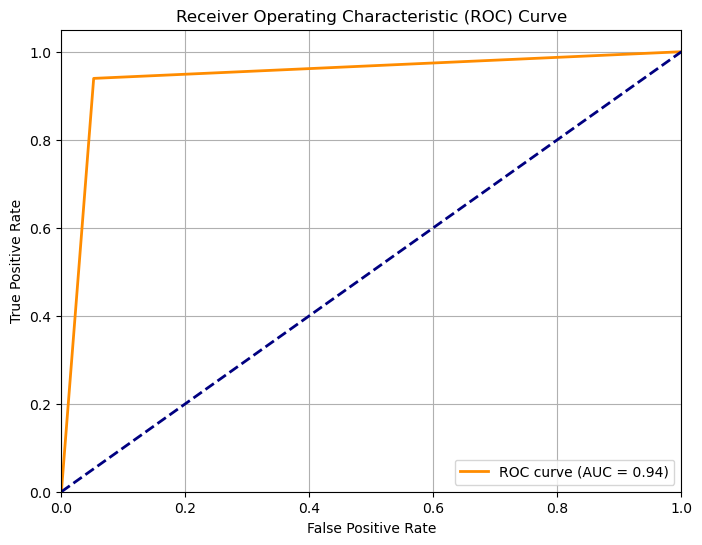

In [224]:
#ROC curve on validation set

from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val, y_pred_val_xgb)

# Calculate AUC
roc_auc = roc_auc_score(y_val, y_pred_val_xgb)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()